# Tangent Linear Code と Adjoint Code を整理しながら書いてみる

# はじめに

## 環境要件


In [70]:
import numpy as np
import matplotlib.pyplot as plt

print(f"numpy: {np.__version__}")

numpy: 1.24.3


## Tangent Linear Code と Adjoint Code の定義

状態空間ベクトル $\vec{x}$ に対する非線形な演算子 $\mathcal{M}$ が与えられたとする。

$$
\vec{y} = \mathcal{M} (\vec{x}) , 
\qquad \vec{x} \in \mathbb{R}^{J}, 
\quad \vec{y} \in \mathbb{R}^{N}.
$$

| 例 | |
|----|-|
| 観測演算子 $\tilde{\mathcal{H}}$ | $\vec{y}^b_i = \tilde{\mathcal{H}} (\vec{x}^f_i)$ |
| 時間発展モデル $\mathcal{M}$ | $\vec{x}^f _{i+1} = \mathcal{M} (\vec{x}^a _{i})$ |

### Tangent Linear model

入力の微小な擾乱に対する出力の応答

$$
\vec{y} + \delta{ \vec{y} } = \mathcal{ M } ( \vec{x} + \delta \vec{x} ).
$$

が線型であると近似する。

$$\delta \vec{y} \approx \mathbf{L} \ \delta \vec{x}.$$

$\mathbf{L}$ はモデル $\mathcal{M}$ を $\vec{x}$ の周りでテイラー展開した時の係数である。

$$
\mathbf{L} = \frac{ \partial \mathcal{M} }{ \partial \vec{x} } \in \mathbb{R}^{N \times J}, 
\qquad \mathrm{L}_{kl} = \frac{ \partial \vec{x}_k }{ \partial x_l }.
$$

この行列 $\mathbf{L}$ を *接線型モデル (Tangent Linear model, TLM)* という。


### Adjoint model

内積を $\langle \vec{a}, \vec{b} \rangle = a_1 b_1 + a_2 b_2 + \cdots + a_n b_n$ とする。接線型モデル $\mathbf{L}$ に対して

$$\langle \vec{y} , \mathbf{L} \vec{x} \rangle = \langle \mathbf{L}^\dagger \vec{y} , \vec{x} \rangle$$

を満たす行列 $\mathbf{L}^\dagger$ を *随伴モデル (Adjoint model, ADJ)* という。$\mathbf{L}$ が実数値行列であるとき、

$$\mathbf{L}^\dagger = \mathbf{L}^T$$

である。


### アルゴリズム

接線型モデル $\mathbf{L}$ や随伴モデル $\mathbf{L}^T$ は、ビッグデータを扱う場合には大抵ものすごい次元の行列になる。ところが、実際に状態空間モデルを動かす場合には $\mathbf{L}, \mathbf{L}^T$ を何らかのベクトルや行列に掛け合わせるような式が頻出するばかりで、行列データとして $\mathbf{L}, \mathbf{L}^T$ を保持しておくメリットは少ない。

そこで、これらの行列そのもの**ではなく**、これらを作用させた結果だけをうまく計算するプログラムが考え出された。このアルゴリズムを *Tangent Linear Code,  Adjoint Code* という。すなわち、

```python: TangentLinearCode.py
def TangentLinearCode(dx1, dx2, ..., dxN): #入力 = 摂動
    # アルゴリズム
    Lx = (dy1, dy2, ..., dyN) #TLMと入力ベクトルxの積
    return Lx #出力 = 応答
```

```python: AdjointCode.py
def AdjointCode(dy1, dy2, ..., dyN): #入力 = 応答
    # アルゴリズム
    LTy = (dx1, dx2, ..., dxJ) #ADJと入力ベクトルyの積
    return LTy #出力 = 摂動
```

のようなプログラムになる。

# 例1: 観測演算子 $\mathcal{H}$ の場合

状態変数ベクトル $\vec{x}$ が風速ベクトル ($u$: 東西方向の風速, $v$: 南北方向の風速) であり、観測演算子 $\mathcal{H}$ によってスカラー風速 $y$ を計算する場合を考える。

$$
\vec{x} = 
\begin{pmatrix}
u \cr v
\end{pmatrix}
, \qquad

y = \mathcal{H} (u, v) = \sqrt{u^2 + v^2}
, \qquad

\vec{x} \in \mathbb{R}^{2}
, \quad
y \in \mathbb{R}.
$$ 

In [71]:
def H(u, v):
    y = np.sqrt(u**2 + v**2)
    return y

## Tangent Linear Code

観測演算子 $\mathcal{H}$ を接線型化していこう。

$$
\begin{aligned}
y &= \sqrt{u^2+v^2} \cr
\iff &y^2 = u^2 + v^2
\end{aligned}
$$

基本場と摂動を考えて、

$$(y_0 + \delta y)^2 = (u_0 + \delta u)^2 + (v_0 + \delta v)^2.$$

二次以上の微小量を無視して

$$
\delta y \approx \frac{u_0}{y_0} \delta u + \frac{v_0}{y_0} \delta v.
$$

したがって、TLMは

$$
\mathbf{L} = 
\begin{pmatrix}
\frac{u_0}{y_0} & \frac{v_0}{y_0}
\end{pmatrix}
\in \mathbb{R}^{1 \times 2}.
$$

In [72]:
def TangentLinearCode(u0, v0, du, dv): #入力 = 基本場 + 摂動
    y0 = H(u0, v0) #基本場の情報を取得

    dy = (u0*du + v0*dv) / y0
    return dy #出力 = 応答

## Adjoint Code

TLM の転置を考えて、

$$
\mathbf{L}^T = 
\begin{pmatrix}
\frac{u_0}{y_0} \\[5pt]
\frac{v_0}{y_0}
\end{pmatrix}
\in \mathbb{R}^{2 \times 1}.
$$

In [73]:
def AdjointCode(u0, v0, dy): #入力 = 基本場 + 応答
    y0 = H(u0, v0) #基本場の情報を取得

    du = dy * u0 / y0
    dv = dy * v0 / y0
    return du, dv #出力 = 摂動

## 動作テスト

恒等式

$$ \lVert \mathbf{L} \ \delta \vec{x} \rVert ^2 = \langle \mathbf{L} \ \delta \vec{x}, \ \mathbf{L} \ \delta \vec{x} \rangle = \langle \delta \vec{x}, \ \mathbf{L}^T \mathbf{L} \ \delta \vec{x} \rangle$$

で、

- $\delta \vec{x}$ :  Tangent Linear Code の入力
- $\mathbf{L} \ \delta \vec{x}$ : Tangent Linear Code の出力
- $\mathbf{L}^T \mathbf{L} \ \delta \vec{x}$ : Tangent Linear Code の出力を Adjoint Code に入力した結果

となるはずである。また、そもそも TLM が

$$\delta \vec{y} = \mathcal{H}(\vec{x} + \delta \vec{x}) - \mathcal{H}(\vec{x}) \approx \mathbf{L} \ \delta \vec{x}.$$

と近似したものであったことを思い出して、

In [74]:
u0, v0 = 10.0, 5.0
du, dv =  1.0, 2.0

Lx = TangentLinearCode(u0, v0, du, dv)
LTLx_u, LTLx_v = AdjointCode(u0, v0, Lx)

dy_true = H(u0+du, v0+dv) - H(u0, v0)

print(f"{dy_true * dy_true} ~= { Lx * Lx } == {du * LTLx_u + dv * LTLx_v}")

3.4524052577349775 ~= 3.1999999999999997 == 3.2


Tangent Linear Code と Adjoint Code がうまく動いていること、そして厳密な $\delta \vec{y}$ に対して TLM が $O \left( \frac{ |\delta \vec{x}| }{ |\vec{x}_0| } \right) = O(0.1)$ の精度で近似できていることが確認された。

## Singular Vector の視覚化

TLM と ADJ に対して *leading Singular Vector* $v_1$ と が存在して、次を満たす。

$$(\mathbf{L}^T \mathbf{L}) \vec{v}_1 = \sigma_1 ^{~2} \vec{v}_1$$

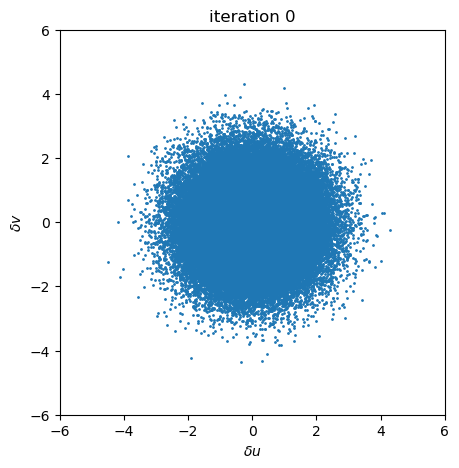

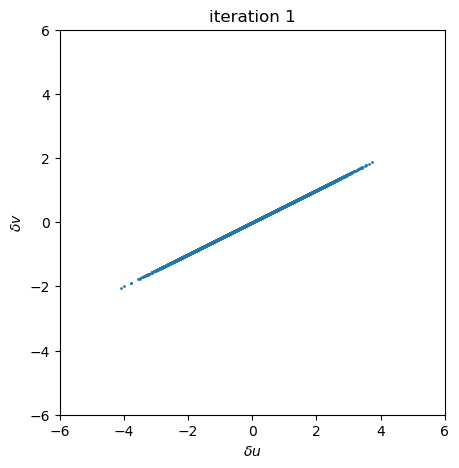

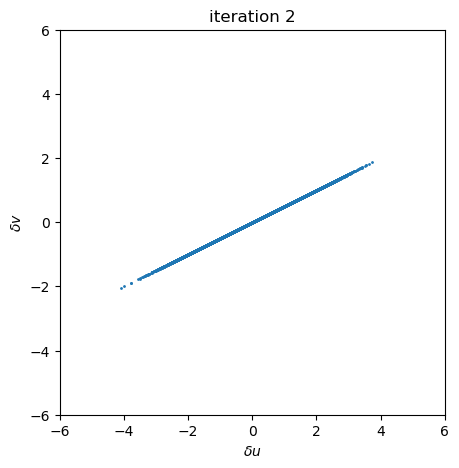

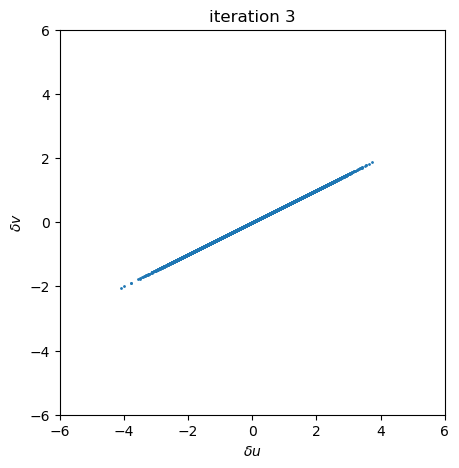

In [75]:
m = 100000
dx_list = np.random.multivariate_normal([0, 0], [[1, 0], [0, 1]], m)

for itr in range(4):
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111)
    ax.scatter(dx_list[:, 0], dx_list[:, 1], s=1)
    ax.set_xlim(-6, 6)
    ax.set_ylim(-6, 6)
    ax.set_xlabel(r"$\delta u$")
    ax.set_ylabel(r"$\delta v$")
    ax.set_title(f"iteration {itr}")
    ax.set_aspect("equal")
    plt.show()
    nx_dx_list = np.zeros((m, 2))
    for k, dx in enumerate(dx_list):
        Lx = TangentLinearCode(u0, v0, dx[0], dx[1])
        LTLx_u, LTLx_v = AdjointCode(u0, v0, Lx)
        nx_dx_list[k, 0], nx_dx_list[k, 1] = LTLx_u, LTLx_v
    dx_list = nx_dx_list

# 例2: 時間発展モデル $\mathcal{M}$ の場合

状態変数ベクトル $\vec{x}$ が Lorentz-63 モデルにしたがって時間発展するとする。

$$
\vec{x} = 
\begin{pmatrix}
x(t) \cr y(t) \cr z(t)
\end{pmatrix}
\in \mathbb{R}^{3}
, \qquad

\frac{ \mathrm{d} \vec{x} }{\mathrm{d} t} = F_\mathrm{L63} (t, \vec{x})

\iff

\left\lbrace
\begin{aligned}
& \frac{\mathrm{d} x}{\mathrm{d} t}=10(y-x), \\[10pt]
& \frac{\mathrm{d} y}{\mathrm{d} t}=x(28-z)-y \\[10pt]
& \frac{\mathrm{d} z}{\mathrm{d} t}=x y-\frac{8}{3} z .
\end{aligned}
\right.
$$

ただし、時間発展は時間グリッドを $\Delta t = 0.05$ にとった 4次の Runge-Kutta 法で数値的に積分して求めるものとする。

$$
\mathrm{RK4} \left( F (t_i, \ \vec{x}_i) \right)
\iff 
\left\lbrace \begin{aligned}
& \vec{k_1} = F\left(t_i, \ \vec{x}_i\right), \cr
& \vec{k_2} = F\left(t_i+\frac{\Delta t}{2}, \ \vec{x}_i+\frac{\Delta t}{2} \cdot k_1\right), \cr
& \vec{k_3} = F\left(t_i+\frac{\Delta t}{2}, \ \vec{x}_i+\frac{\Delta t}{2} \cdot k_2\right), \cr
& \vec{k_4} = F\left(t_i+\Delta t, \ \vec{x}_n+\Delta t \cdot k_3\right).
\end{aligned} \right.
$$

$$
\vec{x}_{i+1} 
= \vec{x}_i + \Delta \vec{x}_i, \qquad
\Delta \vec{x}_i = \frac{\Delta t}{6}\left(\vec{k_1} + 2 \vec{k_2} + 2 \vec{k_3} + \vec{k_4} \right)
$$

時間発展のモデル $\mathcal{M}(t, \cdot)$ は、運動方程式としての Lorentz-63 モデル $F_\mathrm{L63}(t, \cdot)$ ではなく、系の情報を一ステップ分進める数値積分全体としての $\mathrm{RK4} (F_\mathrm{L63} (t, \cdot))$ である。

$$
\vec{x}_{i+1} = \mathcal{M} (t, \vec{x}_i) = \mathrm{RK4} (F_\mathrm{L63} (t_i, \vec{x}_i))
$$

In [92]:
def lorentz63(X, s=10, r=28, b=8/3):
    x, y, z = X # vector X = [x, y, z]
    
    dx = s * (y - x)
    dy = r * x - y - x * z
    dz = x * y - b * z
    return np.array([dx, dy, dz])

In [93]:
def rk4_step(X, Func, Dt=0.05):
    k_weight = np.zeros((4, 3))

    k_weight[0, :] = K1 = Func(X)
    k_weight[1, :] = K2 = Func(X + K1 * Dt / 2)
    k_weight[2, :] = K3 = Func(X + K2 * Dt / 2)
    k_weight[3, :] = K4 = Func(X + K3 * Dt)

    DX = (K1 + 2 * K2 + 2 * K3 + K4) * Dt / 6
    return DX, k_weight

In [94]:
def M(ti, Xi, Dt=0.05):
    DX, k_weight = rk4_step(Xi, lorentz63, Dt=Dt)
    return Xi + DX, k_weight

In [95]:
nX, k_weight = M(0, np.array([1, 1, 1]))

print(f"nX: {nX}")
print(f"k_weight: \n {k_weight}")

nX: [1.29144907 2.39393332 0.96345562]
k_weight: 
 [[ 0.         26.         -1.66666667]
 [ 6.5        25.39166667 -0.90555556]
 [ 4.72291667 29.77902604 -0.70585098]
 [12.52805469 30.93061294  0.50415358]]


## Tangent Linear Code

Runge Kutta 法で Lorentz-63 モデルを数値積分をするとき、例えば重み $\vec{k}_3$ を求めるためには $\vec{k}_2, \vec{k}_1$ までの情報を $F_\mathrm{L63}$ に入力する必要がある。
したがって、時間発展 $\mathcal{M}$ の構造を模式的に書き下すと、

$$
\begin{aligned}
\mathcal{M}(t, \cdot) 
&= \mathrm{RK4} (F_\mathrm{L63} (t, \cdot)) \cr

&= \mathrm{RK4}_{[\Delta \vec{x}]} ( 
    \mathrm{RK4}_{[4 \leftarrow 1]} (F_\mathrm{L63} (t, \cdot)) 
    ) \cr

&= \mathrm{RK4}_{[\Delta \vec{x}]} ( 
    \mathrm{RK4}_{[4]} ( F_\mathrm{L63} (t, 
        \mathrm{RK4}_{[3 \leftarrow 1]} (F_\mathrm{L63} (t, \cdot))
        ))
    ) \cr

&= \cdots \cr

&= \mathrm{RK4}_{[\Delta \vec{x}]} (
    \mathrm{RK4}_{[4]} ( F_\mathrm{L63} (t, 
        \mathrm{RK4}_{[3]} ( F_\mathrm{L63} (t, 
            \mathrm{RK4}_{[2]} ( F_\mathrm{L63} (t, 
                \mathrm{RK4}_{[1]} ( F_\mathrm{L63} (t, \cdot) )
            ))
        ))
    ))
)
\end{aligned}
$$

であるから、$\mathcal{M}, \mathrm{RK4}, F_\mathrm{L63}$ の TLM をそれぞれ $\mathbf{M}, \mathbf{L}_\mathrm{RK4}, \mathbf{L}_\mathrm{L63}$ とすると、以下のような行列の積で表せる。

$$
\mathbf{M} 
= \mathbf{L}_{\mathrm{RK4} [\Delta \vec{x}]} 
\cdot \mathbf{L}_{\mathrm{RK4} [4]} \cdot \mathbf{L}_\mathrm{L63}
\cdot \mathbf{L}_{\mathrm{RK4} [3]} \cdot \mathbf{L}_\mathrm{L63}
\cdot \mathbf{L}_{\mathrm{RK4} [2]} \cdot \mathbf{L}_\mathrm{L63}
\cdot \mathbf{L}_{\mathrm{RK4} [1]} \cdot \mathbf{L}_\mathrm{L63}
$$

したがって、Runge Kutta 法による時間発展モデルの Tangent Linear Code を書くためにはまず Lorentz-63 モデルの TLM が必要である。



### Lorenz-63 モデルの TLM

$$
\delta \left( \frac{\mathrm{d} \vec{x}}{\mathrm{d} t} \right)
= \begin{pmatrix}
\delta \dot{x} \\[10pt] \delta \dot{y} \\[10pt] \delta \dot{z}
\end{pmatrix}
\approx \begin{pmatrix}
\frac{\mathrm{d} F_\mathrm{L63}^x }{\mathrm{d} x} & \frac{\mathrm{d} F_\mathrm{L63}^x }{\mathrm{d} y} & \frac{\mathrm{d} F_\mathrm{L63}^x }{\mathrm{d} z} \\[10pt]
\frac{\mathrm{d} F_\mathrm{L63}^y }{\mathrm{d} z} & \frac{\mathrm{d} F_\mathrm{L63}^y }{\mathrm{d} y} & \frac{\mathrm{d} F_\mathrm{L63}^y }{\mathrm{d} z} \\[10pt]
\frac{\mathrm{d} F_\mathrm{L63}^z }{\mathrm{d}x } & \frac{\mathrm{d} F_\mathrm{L63}^z }{\mathrm{d} y} & \frac{\mathrm{d} F_\mathrm{L63}^z }{\mathrm{d} z} 
\end{pmatrix}
\begin{pmatrix}
\delta x \\[10pt] \delta y \\[10pt] \delta z
\end{pmatrix}
= \begin{pmatrix}
-10  & 10 & 0 \\[10pt]
28-z & -1 & -x \\[10pt]
y    & x  & -\frac{8}{3}
\end{pmatrix}
\begin{pmatrix}
\delta x \\[10pt] \delta y \\[10pt] \delta z
\end{pmatrix}
= \mathbf{L}_\mathrm{L63} \ \delta \vec{x}
$$

In [96]:
def l63_tlm(Xi, dX, s=10, r=28, b=8/3): #入力 = 基本場 + 摂動
    xi, yi, zi = Xi # vector Xi = [xi, yi, zi]
    dx, dy, dz = dX # vector dX = [dx, dy, dz]

    dDx =       -s * dx +  s * dy +   0 * dz
    dDy = (r - zi) * dx + -1 * dy + -xi * dz
    dDz =       yi * dx + xi * dy +  -b * dz
    return np.array([dDx, dDy, dDz]) #出力 = 応答

### 時間発展モデル $\mathcal{M}$ の TLM

In [116]:
def TangentLinearCode(ti, Xi, dX, Dt=0.05): #入力 = 基本場(xi, yi, zi) + 摂動(dxi, dyi, dzi)
    nX, k_weight_i = M(ti, Xi, Dt=Dt) #基本場の情報を取得
    K1i, K2i, K3i, K4i = k_weight_i
    
    # tlm( RK4[1] )
    X0_rk0 = Xi.copy() #lorenz63_tlm が感じる基本場
    dDX1 = l63_tlm(X0_rk0, dX)
    dX_rk1 = dX + dDX1 * Dt / 2

    # tlm( RK4[2] )
    X0_rk1 = Xi + K1i * Dt / 2 #lorenz63_tlm が感じる基本場
    dDX2 = l63_tlm(X0_rk1, dX_rk1)
    dX_rk2 = dX + dDX2 * Dt / 2

    # tlm( RK4[3] )
    X0_rk2 = Xi + K2i * Dt / 2 #lorenz63_tlm が感じる基本場
    dDX3 = l63_tlm(X0_rk2, dX_rk2)
    dX_rk3 = dX + dDX3 * Dt

    # tlm( RK4[4] )
    X0_rk3 = Xi + K3i * Dt #lorenz63_tlm が感じる基本場
    dDX4 = l63_tlm(X0_rk3, dX_rk3)

    # tlm( RK4[ΔX] )
    dnX = dX + (dDX1 + 2 * dDX2 + 2 * dDX3 + dDX4) * Dt / 6
    return dnX #出力 = 応答

## Adjoint Code

$$
\begin{aligned}
\mathbf{M}^T 
&= (\mathbf{L}_{\mathrm{RK4} [\Delta \vec{x}]} 
\cdot \mathbf{L}_{\mathrm{RK4} [4]} \cdot \mathbf{L}_\mathrm{L63}
\cdot \mathbf{L}_{\mathrm{RK4} [3]} \cdot \mathbf{L}_\mathrm{L63}
\cdot \mathbf{L}_{\mathrm{RK4} [2]} \cdot \mathbf{L}_\mathrm{L63}
\cdot \mathbf{L}_{\mathrm{RK4} [1]} \cdot \mathbf{L}_\mathrm{L63})^T \cr
&=    \mathbf{L}_\mathrm{L63}^T \cdot \mathbf{L}_{\mathrm{RK4} [1]}^T 
\cdot \mathbf{L}_\mathrm{L63}^T \cdot \mathbf{L}_{\mathrm{RK4} [2]}^T 
\cdot \mathbf{L}_\mathrm{L63}^T \cdot \mathbf{L}_{\mathrm{RK4} [3]}^T 
\cdot \mathbf{L}_\mathrm{L63}^T \cdot \mathbf{L}_{\mathrm{RK4} [4]}^T 
\cdot\mathbf{L}_{\mathrm{RK4} [\Delta \vec{x}]}^T
\end{aligned}
$$


In [117]:
def l63_adj(Xi, dnX, s=10, r=28, b=8/3): #入力 = 基本場 + 応答
    xi,  yi,  zi  = Xi  # vector  Xi = [xi, yi, zi]
    dnx, dny, dnz = dnX # vector dnX = [dxi, dyi, dzi]

    dxi = -s * dnx + (r - zi) * dny + yi * dnz
    dyi =  s * dnx +       -1 * dny + xi * dnz
    dzi =  0 * dnx +      -xi * dny + -b * dnz
    return np.array([dxi, dyi, dzi]) #出力 = 摂動

In [127]:
def AdjointCode(ti, Xi, dnX, Dt=0.05): #入力 = 基本場(xi, yi, zi) + 応答(dxi, dyi, dzi)
    nX, k_weight_i = M(ti, Xi, Dt=Dt) #基本場の情報を取得
    K1i, K2i, K3i, K4i = k_weight_i

    # adj( RK4[ΔX] )
    dX   = dnX.copy()
    dDX4 = dnX * Dt / 6
    dDX3 = dnX * Dt / 3
    dDX2 = dnX * Dt / 3
    dDX1 = dnX * Dt / 6

    # adj( RK4[4] )
    X0_rk3 = Xi + K3i * Dt #lorenz63_adj が感じる基本場
    dX_rk3 = l63_adj(X0_rk3, dDX4)
    dDX3 = dDX3 + dX_rk3 * Dt
    dX += dX_rk3

    # adj( RK4[3] )
    X0_rk2 = Xi + K2i * Dt / 2 #lorenz63_adj が感じる基本場
    dX_rk2 = l63_adj(X0_rk2, dDX3)
    dDX2 = dDX2 + dX_rk2 * Dt / 2
    dX += dX_rk2

    # adj( RK4[2] )
    X0_rk1 = Xi + K1i * Dt / 2 #lorenz63_adj が感じる基本場
    dX_rk1 = l63_adj(X0_rk1, dDX2)
    dDX1 = dDX1 + dX_rk1 * Dt / 2
    dX += dX_rk1

    # adj( RK4[1] )
    X0_rk0 = Xi #lorenz63_adj が感じる基本場
    dX_rk0 = l63_adj(X0_rk0, dDX1)
    dX += dX_rk0
    
    return dX #出力 = 摂動

## 動作テスト

恒等式

$$ \lVert \mathbf{M} \ \delta \vec{x}_i \rVert ^2 = \langle \mathbf{M} \ \delta \vec{x}_i, \ \mathbf{M} \ \delta \vec{x}_i \rangle = \langle \delta \vec{x}_i, \ \mathbf{M}^T \mathbf{M} \ \delta \vec{x}_i \rangle$$

で、

- $\delta \vec{x}_i$ :  Tangent Linear Code の入力
- $\mathbf{M} \ \delta \vec{x}_i$ : Tangent Linear Code の出力
- $\mathbf{M}^T \mathbf{M} \ \delta \vec{x}_i$ : Tangent Linear Code の出力を Adjoint Code に入力した結果

となるはずである。また、そもそも TLM が

$$\delta \vec{x}_{i+1} = \mathcal{M}(\vec{x}_i + \delta \vec{x}) - \mathcal{M}(\vec{x}_i) \approx \mathbf{M} \ \delta \vec{x}_i.$$

と近似したものであったことを思い出して、

In [128]:
X0 = np.array([10, 20, 30])
dX0 = np.array([1, 2, 3])

Lx = l63_tlm(X0, dX0)
LTLx = l63_adj(X0, Lx)

print(f"{np.dot(dX0, LTLx)} == {np.dot(Lx, Lx)}")

2280.0 == 2280.0


In [129]:
X0 = np.array([10, 20, 30])
dX0 = np.array([1, 2, 3])

Mx = TangentLinearCode(0, X0, dX0)
MTMx = AdjointCode(0, X0, Mx)

dX_true = M(0, X0 + dX0)[0] - M(0, X0)[0]

print(f"{np.dot(dX_true, dX_true)} ~= { np.dot(Mx, Mx) } == { np.dot(dX0, MTMx) }")

16.588074147597972 ~= 16.700646822453045 == 16.70064682245304
